In [1]:
import numpy as np
from math import sqrt
from random import normalvariate
from numpy.linalg import svd as svd_np
from numpy.linalg import eig
from numpy.linalg import norm

In [2]:
def fro_norm(x):
    return sqrt((x**2).sum().astype('float64'))

In [3]:
def normalize_vec(x):
    return x / sqrt((x**2).sum())

In [4]:
def generateUnitVector(n):
    return normalize_vec(np.arange(n))

In [5]:
def cov(A):
    n, m = A.shape
    avg = A.mean(axis=0)
    A = A - avg
    if n >= m:
        B = np.dot(A.T, A)
    else:
        B = np.dot(A, A.T)
    return B / float(A.shape[0])

Test Frobenius Norm.

In [6]:
a = np.array([[1,2,3,4], [4,3,2,1]])
print a
print fro_norm(a)

[[1 2 3 4]
 [4 3 2 1]]
7.74596669241


Test Normalizing Vector.

In [7]:
a = np.array([3,4,5,6])
b = normalize_vec(a)
print b.dot(b)

1.0


Compare Covariance Matrix

In [8]:
testMatrix = np.random.randint(5, size=(5, 5))

print 'Original Matrix:\n {}'.format(testMatrix)

# Self implemented covariance
my_cov = cov(testMatrix)
# numpy implemented covariance
np_cov = np.cov(testMatrix, rowvar=0, ddof=0)

print 'Test Matrix: \n {}'.format(testMatrix)
print 'My covariance implementation: \n {}'.format(my_cov)
print 'Numpy covariance implementation: \n {}'.format(np_cov)

Original Matrix:
 [[2 4 1 1 2]
 [0 4 1 4 4]
 [2 2 1 0 3]
 [2 2 3 0 3]
 [0 3 4 4 3]]
Test Matrix: 
 [[2 4 1 1 2]
 [0 4 1 4 4]
 [2 2 1 0 3]
 [2 2 3 0 3]
 [0 3 4 4 3]]
My covariance implementation: 
 [[ 0.96 -0.4  -0.4  -1.76 -0.4 ]
 [-0.4   0.8  -0.4   1.    0.  ]
 [-0.4  -0.4   1.6   0.6   0.  ]
 [-1.76  1.    0.6   3.36  0.6 ]
 [-0.4   0.    0.    0.6   0.4 ]]
Numpy covariance implementation: 
 [[ 0.96 -0.4  -0.4  -1.76 -0.4 ]
 [-0.4   0.8  -0.4   1.    0.  ]
 [-0.4  -0.4   1.6   0.6   0.  ]
 [-1.76  1.    0.6   3.36  0.6 ]
 [-0.4   0.    0.    0.6   0.4 ]]


Core of power method for SVD decomposition.

In [9]:
def svd_1d(A, epsilon=2**(-17)):
    n, m = A.shape
    x = generateUnitVector(min(n,m))  # Due to hardware constraints
    
    lastV = None
    currentV = x
    
    if n >= m:
        B = np.dot(A.T, A)
    else:
        B = np.dot(A, A.T)
        
    iterations = 0
    while True:
        iterations += 1
        lastV = currentV
        currentV = np.dot(B, lastV)
        currentV = currentV / fro_norm(currentV)
        
        if abs(np.dot(currentV, lastV)) > 1 - epsilon:
            print("converged in {} iterations!".format(iterations))
            return currentV


In [10]:
def svd(A, k=None, epsilon=2**(-17)):
    '''
        Compute the singular value decomposition of a matrix A
        using the power method. A is the input matrix, and k
        is the number of singular values you wish to compute.
        If k is None, this computes the full-rank decomposition.
    '''
    A = np.array(A, dtype=float)
    n, m = A.shape
    svdSoFar = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        matrixFor1D = A.copy()

        for singularValue, u, v in svdSoFar[:i]:
            matrixFor1D -= singularValue * np.outer(u, v)
        if n >= m:
            v = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            u_unnormalized = np.dot(A, v)
            sigma = fro_norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            u = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            v_unnormalized = np.dot(A.T, u)
            sigma = fro_norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svdSoFar.append((sigma, u, v))

    singularValues, us, vs = [np.array(x) for x in zip(*svdSoFar)]
    return singularValues, us.T, vs

In [11]:
def pca_np(dataMat, topNfeat=9999999):
    meanVals = np.mean(dataMat, axis=0)
    meanRemoved = dataMat - meanVals #remove mean
    covMat = np.cov(meanRemoved, rowvar=0, ddof=0)
    eigVects, eigVals, _ = svd_np(covMat)
    eigValInd = np.argsort(eigVals)            #sort, sort goes smallest to largest
    eigValInd = eigValInd[:-(topNfeat+1):-1]  #cut off unwanted dimensions
    redEigVects = eigVects[:,eigValInd]       #reorganize eig vects largest to smallest
    redEigVal = eigVals[eigValInd] # return reduced eig val for whitening
    lowDDataMat = meanRemoved.dot(redEigVects)#transform data into new dimensions
    return lowDDataMat, redEigVects, redEigVal

# For SVD using power method, sorting is not needed!
def pca(dataMat, topNfeat=9999999, epsilon=2**(-17)):
    meanVals = np.mean(dataMat, axis=0)
    meanRemoved = dataMat - meanVals #remove mean
    covMat = cov(meanRemoved)
    eigVals, eigVects, _ = svd(covMat, epsilon=epsilon, k = topNfeat)
    lowDDataMat = meanRemoved.dot(eigVects)#transform data into new dimensions
    return lowDDataMat, eigVects, eigVals

Compare singular vectors

i: 0
converged in 1 iterations!
converged in 1 iterations!
converged in 1 iterations!
converged in 1 iterations!
converged in 1 iterations!
i: 1
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
i: 2
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
i: 3
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
i: 4
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
i: 5
converged in 2 iterations!
converged in 3 iterations!
converged in 2 iterations!
converged in 2 iterations!
converged in 3 iterations!
i: 6
converged in 3 iterations!
converged in 3 iterations!
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
i: 7
converged in 3 

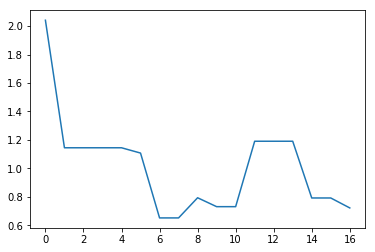

In [14]:
import pylab

testMatrix = np.random.randint(5, size=(5, 5))
my_cov = cov(testMatrix)
np_cov = np.cov(testMatrix, rowvar=0, ddof=0)

error = []
for i in range(17):
    print 'i: {}'.format(i)
    s, u, v = svd(my_cov, epsilon=2**(-i))
    u_np, s_np, v_np = svd_np(np_cov, 3)
    error.append(((abs(u_np) - abs(u))**2).sum())

pylab.plot(error)

Compare dimension reduced matrix

i: 0
converged in 1 iterations!
converged in 1 iterations!
converged in 1 iterations!
[[0 1 3 1 3]
 [0 1 4 4 3]
 [0 4 3 4 2]
 [0 3 0 3 3]
 [4 1 2 2 2]]
[[-0.39952179  0.71065559 -2.20170145]
 [ 1.15199327  1.48102063 -0.95115906]
 [ 2.0182001  -0.86286222  1.34275175]
 [ 0.57836833 -2.67495423  1.03021238]
 [-3.34903992  1.34614023  0.77989637]]
i: 1
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
[[0 1 3 1 3]
 [0 1 4 4 3]
 [0 4 3 4 2]
 [0 3 0 3 3]
 [4 1 2 2 2]]
[[-0.47240032  1.09952726 -2.05468838]
 [ 0.90849315  1.90148259 -0.09540623]
 [ 2.03591122 -0.578529    1.39531562]
 [ 0.89541192 -2.52970829 -0.29411076]
 [-3.36741596  0.10722743  1.04888975]]
i: 2
converged in 2 iterations!
converged in 2 iterations!
converged in 2 iterations!
[[0 1 3 1 3]
 [0 1 4 4 3]
 [0 4 3 4 2]
 [0 3 0 3 3]
 [4 1 2 2 2]]
[[-0.47240032  1.09952726 -2.05468838]
 [ 0.90849315  1.90148259 -0.09540623]
 [ 2.03591122 -0.578529    1.39531562]
 [ 0.89541192 -2.52970829 -0.294110

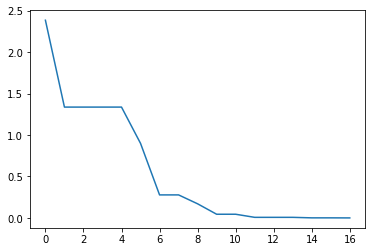

In [16]:
error = []

lowDDataMat, redEigVects, redEigVal = pca_np(testMatrix, 3)

for i in range(17):
    print "i: {}".format(i)
    lowDDataMat_, redEigVects_, redEigVal_ = pca(testMatrix, 3, epsilon=2**(-i))
    error.append(((abs(lowDDataMat_) - abs(lowDDataMat))**2).sum())

pylab.plot(error)

In [20]:
for i in range(10):
    testMatrix = np.random.randint(8, size=(5, 5))
    lowDDataMat_, redEigVects_, redEigVal_ = pca(testMatrix, 3, epsilon=2**(-17))
    print testMatrix
    print lowDDataMat_

converged in 6 iterations!
converged in 4 iterations!
converged in 2 iterations!
[[6 5 5 0 7]
 [7 5 2 7 1]
 [5 4 1 6 1]
 [2 5 3 2 3]
 [0 4 7 6 6]]
[[ 3.90474827 -4.35425597  1.05910119]
 [-4.86941182 -0.18339078  1.51555328]
 [-4.13352142  0.36315909 -0.64050362]
 [ 1.10240528 -0.30116276 -2.87736246]
 [ 3.99577969  4.47565042  0.94321161]]
converged in 5 iterations!
converged in 7 iterations!
converged in 2 iterations!
[[4 4 4 3 4]
 [6 7 3 1 2]
 [1 6 6 0 5]
 [0 6 6 1 0]
 [1 3 2 7 3]]
[[ 1.08309866 -1.49146167  1.20168075]
 [-1.69844097 -3.93305776 -1.29315977]
 [-2.71412098  1.41578045  2.61889933]
 [-2.29018587  3.01258654 -2.25165762]
 [ 5.61964917  0.99615244 -0.2757627 ]]
converged in 7 iterations!
converged in 3 iterations!
converged in 2 iterations!
[[2 5 6 7 1]
 [5 5 5 5 5]
 [6 0 0 6 7]
 [1 6 3 0 5]
 [4 4 3 4 6]]
[[-3.79095138  3.99125603 -1.13863309]
 [-0.52182061  1.04667215  2.12782873]
 [ 6.29687586  0.47809166 -0.90441519]
 [-2.82938466 -4.66395782 -0.69682501]
 [ 0.845280